In [1]:
import sys, os
import pickle
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
with open('mnist_X_train.pkl', 'rb') as f:
    X = pickle.load(f)

with open('mnist_y_train.pkl', 'rb') as f:
    y = pickle.load(f)

In [5]:
# See how well KNN does with just the pixels alone
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

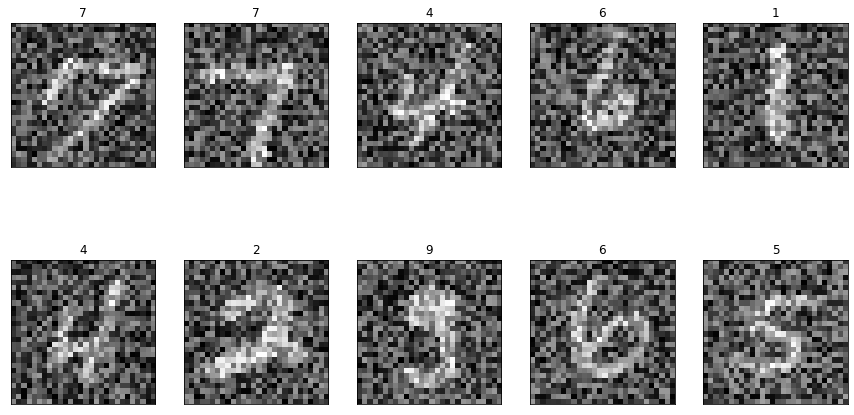

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(15,8), subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(y_train, X_train, axes.ravel()):
    ax.imshow(image.reshape((28, 28)), cmap='gray')
    ax.set_title(target)

# KNN with naked data

In [7]:
knn_naked = KNeighborsClassifier(n_neighbors=4, n_jobs=8)
knn_naked.fit(X_train, y_train)
print(f"Test set score of 4-nn: {knn_naked.score(X_test, y_test):.5f}")

Test set score of 4-nn: 0.87158


# KNN with standardization

In [8]:
scaler_naked = StandardScaler().fit(X_train)
X_train_std = scaler_naked.transform(X_train)
X_test_std = scaler_naked.transform(X_test)

In [9]:
knn_std = KNeighborsClassifier(n_neighbors=4, n_jobs=8)
knn_std.fit(X_train_std, y_train)
print(f"Test set score of 4-nn: {knn_std.score(X_test_std, y_test):.5f}")

Test set score of 4-nn: 0.81150


# KNN with data denoising

In [10]:
from scipy.ndimage.filters import gaussian_filter

def transform_data(data):
    mask = data > np.max(data)*0.65
    mask = mask.astype(float)
    for i in range(0, mask.shape[0]):
        mask[i] = gaussian_filter(mask[i], sigma=0.7)
    mask = mask > (np.max(mask) - np.mean(mask))/8 + np.mean(mask)
    mask = mask.astype(float)
    return mask

In [11]:
X_train_transformed = transform_data(X_train)
X_test_transformed = transform_data(X_test)

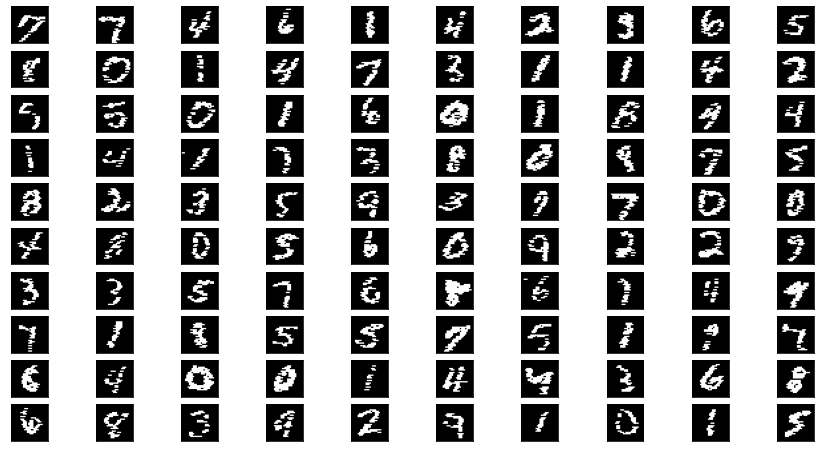

In [45]:
fig, axes = plt.subplots(10, 10, figsize=(15,8), subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(y_train, X_train_transformed, axes.ravel()):
    ax.imshow(image.reshape((28, 28)), cmap='gray')
    # ax.set_title(target)

In [13]:
knn_transformed = KNeighborsClassifier(n_neighbors=4, n_jobs=8)
knn_transformed.fit(X_train_transformed, y_train)
print(f"Test set score of 4-nn: {knn_transformed.score(X_test_transformed, y_test):.5f}")

Test set score of 4-nn: 0.90292


# KNN with denoising and standardization

In [14]:
scaler_transformed = StandardScaler().fit(X_train_transformed)
X_train_trans_std = scaler_transformed.transform(X_train_transformed)
X_test_trans_std = scaler_transformed.transform(X_test_transformed)

In [15]:
knn_transformed_std = KNeighborsClassifier(n_neighbors=4, n_jobs=8)
knn_transformed_std.fit(X_train_trans_std, y_train)
print(f"Test set score of 4-nn: {knn_transformed_std.score(X_test_trans_std, y_test):.5f}")

Test set score of 4-nn: 0.86250


# KNN with PCA using denoised data transform

In [37]:
N_COMPONENTS = 40

In [38]:
pca_trans = PCA(n_components=N_COMPONENTS).fit(X_train_transformed)
X_train_trans_proj = pca_trans.transform(X_train_transformed)
X_test_trans_proj = pca_trans.transform(X_test_transformed)

In [39]:
knn_transformed_pca = KNeighborsClassifier(n_neighbors=4, n_jobs=8)
knn_transformed_pca.fit(X_train_trans_proj, y_train)
print(f"Test set score of 4-nn: {knn_transformed_pca.score(X_test_trans_proj, y_test):.5f}")

Test set score of 4-nn: 0.93925


In [ ]:
knn_transformed_pca = KNeighborsClassifier(n_neighbors=1, n_jobs=8)
knn_transformed_pca.fit(X_train_trans_proj, y_train)
print(f"Test set score of 4-nn: {knn_transformed_pca.score(X_test_trans_proj, y_test):.5f}")

In [42]:
with open('X_train_trans_proj.pkl', 'wb') as f:
    pickle.dump(X_train_trans_proj, f)

with open('X_test_trans_proj.pkl', 'wb') as f:
    pickle.dump(X_test_trans_proj, f)

with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)

with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

# Scratch pad

In [ ]:
# euclid = lambda a, b: np.linalg.norm(a-b)

# def assign_points_to_clusters(centroids, dataset):
#     clusters = []
#     distances = []
#     for i, point in enumerate(dataset):
#         distances.clear()
#         for j, centroid in enumerate(centroids):
#             dist = euclid(point, centroid)
#             distances.append((j, dist))
#         distances.sort(key=lambda tup: tup[1])
#         clusters.append(distances[0][0])
#     return np.array(clusters)

# def calc_new_centroids(clusters, dataset):
#     new_centroids = []
#     for c in set(clusters):
#         points_in_cluster = np.where(clusters == c)
#         cluster_mean = dataset[points_in_cluster].mean(axis=0)
#         new_centroids.append(cluster_mean)
#     return np.array(new_centroids)

# def calc_centroids_diff(old_C, new_C):
#     dists = []
#     for i in range(len(old_C)):
#         dists.append(euclid(old_C[i], new_C[i]))
#     return np.sum(dists)

# def PCA_recon(imgs_proj, V, k, variance, mean):
#     img = imgs_proj[:,:k].reshape(-1, k)
#     recon_img = img @ (V[:,:k].T.reshape(k, -1))
#     recon_img = recon_img * np.sqrt(variance) + mean
#     return recon_img

In [ ]:
# np.random.seed(0)

# # randomly choose k points as k centroids
# centroids_change = 100
# eps = 2e-23
# k = 10
# itr = 1
# max_itr = 30
# centroids = X_train_proj[np.random.randint(0, X_train_proj.shape[0], size=k)]
# new_centroids = None

# while True:
#     clusters = assign_points_to_clusters(centroids, X_train_proj)
#     new_centroids = calc_new_centroids(clusters, X_train_proj)
#     centroids_change = calc_centroids_diff(centroids, new_centroids)

#     if centroids_change < eps or itr > max_itr:
#         break

#     centroids = new_centroids
#     print(f"Iter: {itr}, Change: {centroids_change}")
#     itr += 1

In [ ]:
# report_imgs = []

# for i, C in enumerate(new_centroids):
#     report_imgs.append(C)
#     points_in_cluster = np.where(clusters == i)[0]
#     distances = []
#     for j, p in enumerate(points_in_cluster):
#         distances.append((j, euclid(X_train_proj[p], C)))
#     distances.sort(key=lambda tup: tup[1])
#     closest = distances[0][0]
#     farthest = distances[-1][0]
#     report_imgs.append(X_train_proj[points_in_cluster[closest]])
#     report_imgs.append(X_train_proj[points_in_cluster[farthest]])

# report_imgs = np.array(report_imgs)
# recon_imgs_100_comp = pca.inverse_transform(report_imgs)

In [ ]:
# fig, axes = plt.subplots(10, 3, figsize=(30,18), subplot_kw={'xticks': (), 'yticks': ()})


# for i, ax in zip(recon_imgs_100_comp, axes.ravel()):
#     ax.imshow(i.reshape(28, 28), cmap='gray')

# for title, ax in zip(["Centroid", "Closest to centroid in cluster", "Furthest to centroid in cluster"], axes.flatten()[:3]):
#     ax.axis("off")
#     ax.set_title(f"{title}", fontweight='bold')

In [ ]:
# from scipy.ndimage.filters import gaussian_filter

# fig, axes = plt.subplots(10, 10, figsize=(15,8), subplot_kw={'xticks': (), 'yticks': ()})
# for target, image, ax in zip(y_train, X_train, axes.ravel()):
#     mask = image > np.max(image)*0.65
#     mask = mask.astype(float)
#     blurred = gaussian_filter(mask, sigma=0.7)
#     mask2 = blurred > (np.max(blurred) - np.mean(blurred))/8 + np.mean(blurred)
#     ax.imshow(mask2.reshape((28,28)), cmap='gray')
#     ax.set_title(target)